In [58]:
import sys
from chainer import optimizers
import chainer
import gym
import gym.wrappers
import numpy as np
import chainerrl
from chainerrl import experiments
from chainerrl import explorers
from chainerrl import misc
from chainerrl import q_functions
from chainerrl import replay_buffer

import atari_wrappers

In [59]:
seed = 0
env_name = "SeaquestNoFrameskip-v4"
batch_size = 32

In [60]:
misc.set_random_seed(seed)

In [61]:
def make_env():
    env = gym.make(env_name)
    env = atari_wrappers.wrap_deepmind(
        atari_wrappers.make_atari(env_name),
        episode_life=False,
        clip_rewards=False,
    )
    env.seed(seed)
    misc.env_modifiers.make_rendered(env)
    return env

In [62]:
env = make_env()

In [63]:
timestep_limit = env.spec.tags.get("wrapper_config.TimeLimit.max_episode_steps")
obs_size = env.observation_space.low.size
action_size = env.action_space.n
obs_space = env.observation_space
action_space = env.action_space

print(timestep_limit)
print(obs_space)
print(action_space)

400000
Box(4, 84, 84)
Discrete(18)


In [64]:
n_atoms = 51
v_max = 10
v_min = -10

In [65]:
q_func = chainerrl.links.Sequence(
    chainerrl.links.NatureDQNHead(),
    chainerrl.q_functions.DistributionalFCStateQFunctionWithDiscreteAction(
        None, action_size, n_atoms, v_min, v_max,
        n_hidden_channels=0, n_hidden_layers=0,
    )
)

In [71]:
explorer = explorers.LinearDecayEpsilonGreedy(
    1,0, 0.1, 10**6, lambda: np.random.randint(action_size),
)

In [72]:
opt = chainer.optimizers.Adam(2.5e-4, eps=1e-2 / batch_size)
opt.setup(q_func)

In [73]:
rbuf = replay_buffer.ReplayBuffer(10 ** 6)

In [74]:
def phi(x):
    return np.asarray(x, dtype=np.float32) / 255

In [75]:
agent = chainerrl.agents.CategoricalDQN(
    q_func, opt, rbuf, gpu=-1, gamma= 0.99, explorer=explorer, replay_start_size=5 * 10 ** 4,
    target_update_interval=10 ** 4, update_interval=4, batch_accumulator="mean", phi=phi,
)

In [76]:
agent.load("/Users/sykwer/work/i18-sykwer/experiments/visualize_naf/results/213921/20180807T064140.265982/50000000_finish")

## stepごとの, 出力されたReturnの分布を可視化する

In [81]:
obs = env.reset()
action_value = agent.model(agent.batch_states([obs], agent.xp, agent.phi))

In [90]:
action_value.z_values

array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
        -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
        -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
         0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
         4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
         8. ,   8.4,   8.8,   9.2,   9.6,  10. ], dtype=float32)

In [93]:
action_value.q_dist[0].shape

(18, 51)

In [104]:
import matplotlib.pyplot as plt

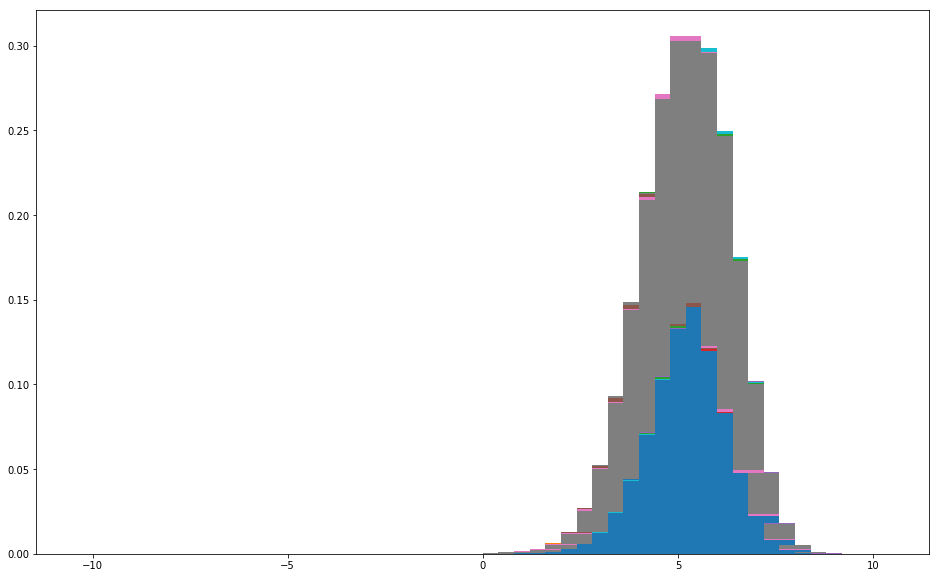

In [110]:
fig = plt.figure(figsize=[16, 10])
ax = fig.add_subplot(111)
idx = 0
prev_qvalues = None

for qvalues in action_value.q_dist.data[0]:
    if idx == 0:
        ax.bar(action_value.z_values, qvalues)
    else:
        ax.bar(action_value.z_values, qvalues, bottom=prev_qvalues)
    idx += 1
    prev_qvalues = qvalues

plt.show()

In [114]:
action_value.q_values

variable([[5.1827903, 5.1831236, 5.1634855, 5.2140036, 5.1975193,
           5.2071257, 5.176357 , 5.1749372, 5.219316 , 5.209268 ,
           5.1708865, 5.205624 , 5.197775 , 5.2020836, 5.1860065,
           5.175556 , 5.2009106, 5.206838 ]])

# Q値の時系列変化の可視化